<a href="https://colab.research.google.com/github/A01793509/Equipo_44/blob/main/Avance5_44_copia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 **Avance 5. Modelo final**: Mejorar significativamente el rendimiento al aprovechar las fortalezas de diferentes modelos y reducir sus debilidades.Evaluar la calidad de las predicciones del modelo en datos no vistos.

📑 **Asignatura**: Proyecto Integrador

📘 **Proyecto**: LunchForecast AI: Optimizador de reservas de almuerzos empresariales basado en inteligencia artificial.

📚 **Equipo**: 44

🧑 **Alumnos**:

Alberto José García Porras (Matrícula No. **A01793509**)

Erick Johan Najera Olivero (Matrícula No. **A01793506**)

Carlos Julio León Caicedo (Matrícula No. **A01793947**)

👩 **Profesores**:

Dra. Grettel Barceló Alonso

Dr. Luis Eduardo Falcón Morales

Dr. Guillermo Mota

📅 Junio 2 del 2024

In [73]:
#!pip install scikeras

In [74]:
#Importamos las librerías que utilizaremos para la ejecución de la actividad
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import numpy as np
import warnings
import statsmodels.api as sm
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,  make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.optimizers import Adam
#from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.ensemble import StackingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn import tree
from scipy.stats import randint, uniform

👣**Obtener Datos**: Cargamos el archivo CSV con la información del consumo del casino desde enero del 2021 hasta marzo del 2024.

In [75]:
dfCasinoConsumo = pd.read_csv("DatosConsumoCasino.csv",sep=";")
dfCasinoConsumoOriginal = dfCasinoConsumo
dfCasinoConsumo.head()

,Consecutivo,IdProducto,cod lector,Cod comedor,Identificacion persona,Fecha Consumo,Detalle,Nro empleados,Tipo Empleado,Nivel,Porcentaje apoyo,Invitado,Ing x planta
0,825979,2.0,0,1001,100001,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
1,825980,2.0,0,1001,100002,2021-01-03,ALMUERZO,3486,Administrativo,ANAL,90,0,1
2,825981,2.0,0,1001,100003,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
3,825982,2.0,1,1001,100004,2021-01-03,ALMUERZO,3486,Operativo,OPER,90,0,1
4,825983,2.0,0,1001,100005,2021-01-03,ALMUERZO,3486,Administrativo,OPER,0,0,1



---

☝**NOTA:** En este entregable iniciaremos aplicando los ajustes detectados en los entregables anteriores, referentes a la depuración de los datos y la ingeniería de características.


---




---


👣 **SECCIÓN 1:** Limpieza y ajuste del conjunto de datos.



---



In [76]:
# Convierte la columna 'fecha del consumo' a tipo datetime si aún no lo está
dfCasinoConsumo['Fecha Consumo'] = pd.to_datetime(dfCasinoConsumo['Fecha Consumo'], format='%Y-%m-%d', errors='coerce')
#dfCasinoConsumo = dfCasinoConsumo.set_index('Fecha Consumo')
dfCasinoConsumo.head()

,Consecutivo,IdProducto,cod lector,Cod comedor,Identificacion persona,Fecha Consumo,Detalle,Nro empleados,Tipo Empleado,Nivel,Porcentaje apoyo,Invitado,Ing x planta
0,825979,2.0,0,1001,100001,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
1,825980,2.0,0,1001,100002,2021-01-03,ALMUERZO,3486,Administrativo,ANAL,90,0,1
2,825981,2.0,0,1001,100003,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
3,825982,2.0,1,1001,100004,2021-01-03,ALMUERZO,3486,Operativo,OPER,90,0,1
4,825983,2.0,0,1001,100005,2021-01-03,ALMUERZO,3486,Administrativo,OPER,0,0,1


In [77]:
#En el análisis, habíamos notado que existían valores de 'ALMUERZO' en minúsculas en el campo 'DETALLE'
#Por lo anterior, procederemos a pasar a mayúsculas el contenido de la columna antes de proceder con el borrado
dfCasinoConsumo['Detalle'] = dfCasinoConsumo['Detalle'].str.upper()

#Filtramos el dataFrame para conservar solo las filas donde 'DETALLE' es igual a 'ALMUERZO' y lo guardamos en un
#nuevo dataframe para evitar SettingWithCopyWarning
dfCasinoAlmuerzos = dfCasinoConsumo[dfCasinoConsumo['Detalle'] == 'ALMUERZO'].copy()

In [78]:
#Eliminamos las columnas que no consideramos relevantes según hallazgos en la fase de exploración
#dfCasinoConsumo=dfCasinoConsumo.drop(columns=['Consecutivo', 'Detalle','IdProducto', 'cod lector', 'Cod comedor', 'Identificacion persona', 'Invitado','Ing x planta','Nro empleados','Nivel'])
dfCasinoConsumo=dfCasinoAlmuerzos.drop(columns=['Consecutivo', 'Detalle','IdProducto', 'cod lector', 'Cod comedor', 'Identificacion persona', 'Invitado','Ing x planta','Nro empleados','Nivel'])
dfCasinoConsumo.head()

,Fecha Consumo,Tipo Empleado,Porcentaje apoyo
0,2021-01-03,Operativo,0
1,2021-01-03,Administrativo,90
2,2021-01-03,Operativo,0
3,2021-01-03,Operativo,90
4,2021-01-03,Administrativo,0


**pd.get_dummies():** Esta función se utilizó para convertir las variables categóricas Tipo Empleado y Porcentaje apoyo en un conjunto de variables indicadoras (también llamadas variables dummy). Es una técnica comúnmente usada en la preparación de datos para modelos de aprendizaje automático, particularmente útil cuando se trata con modelos que requieren entradas numéricas exclusivamente.

In [79]:
#Procedemos a realizar la codificación de las columnas categóricas
dfCasinoAlmuerzosCodificado = pd.get_dummies(dfCasinoConsumo, columns=['Tipo Empleado',  'Porcentaje apoyo'])
dfCasinoAlmuerzosCodificado.head()

,Fecha Consumo,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,False,False,True,True,False,False,False
1,2021-01-03,True,False,False,False,False,True,False
2,2021-01-03,False,False,True,True,False,False,False
3,2021-01-03,False,False,True,False,False,True,False
4,2021-01-03,True,False,False,True,False,False,False


In [80]:
#Para que el modelo que desarrollaremos más adelante funcione de una mejor manera,
#procederemos a convertir los valores booleanos a números.
#Recorremos todas las columnas y al identificar una booleana, la convertiremos en número.
for col in dfCasinoAlmuerzosCodificado.columns:
    if dfCasinoAlmuerzosCodificado[col].dtype == bool:
        dfCasinoAlmuerzosCodificado[col] = dfCasinoAlmuerzosCodificado[col].astype(int)

dfCasinoAlmuerzosCodificado.head(5)

,Fecha Consumo,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,0,0,1,1,0,0,0
1,2021-01-03,1,0,0,0,0,1,0
2,2021-01-03,0,0,1,1,0,0,0
3,2021-01-03,0,0,1,0,0,1,0
4,2021-01-03,1,0,0,1,0,0,0


In [81]:
dfCasinoAlmuerzosCodificado

,Fecha Consumo,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,0,0,1,1,0,0,0
1,2021-01-03,1,0,0,0,0,1,0
2,2021-01-03,0,0,1,1,0,0,0
3,2021-01-03,0,0,1,0,0,1,0
4,2021-01-03,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
875441,2024-03-20,1,0,0,0,1,0,0
875442,2024-03-21,1,0,0,0,1,0,0
875443,2024-03-22,1,0,0,0,1,0,0
875444,2024-03-26,1,0,0,0,1,0,0


In [82]:
# Agrupar por 'Fecha' y realizar las agregaciones necesarias para olumnas codificadas como dummies con la función agg()
dfAlmuerzoAgrupado = dfCasinoAlmuerzosCodificado.groupby('Fecha Consumo').agg({
    'Tipo Empleado_Administrativo': 'sum',
    'Tipo Empleado_Aprendices': 'sum',
    'Tipo Empleado_Operativo': 'sum',
    'Porcentaje apoyo_0': 'sum',
    'Porcentaje apoyo_30': 'sum',
    'Porcentaje apoyo_90': 'sum',
    'Porcentaje apoyo_100': 'sum'
}).reset_index()

In [83]:
# Agregar una nueva columna con el conteo de registros por fecha
dfAlmuerzoAgrupado['Cantidad Almuerzos'] = dfCasinoAlmuerzosCodificado.groupby('Fecha Consumo').size().values

In [84]:
# Convertir fechas a formato datetime
dfAlmuerzoAgrupado['Fecha Consumo'] = pd.to_datetime(dfAlmuerzoAgrupado['Fecha Consumo'])

# Nos aseguramos de que el DataFrame esté ordenado por fecha para que cualquier operación
# o visualización a realizar con los datos siga el orden cronológico correcto.
dfAlmuerzoAgrupado = dfAlmuerzoAgrupado.sort_values('Fecha Consumo')

# Configurar la fecha como el índice
dfAlmuerzoAgrupado.set_index('Fecha Consumo', inplace=True)
dfAlmuerzoAgrupado.index

DatetimeIndex(['2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06',
               '2021-01-07', '2021-01-08', '2021-01-09', '2021-01-10',
               '2021-01-11', '2021-01-12',
               ...
               '2024-03-22', '2024-03-23', '2024-03-24', '2024-03-25',
               '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29',
               '2024-03-30', '2024-03-31'],
              dtype='datetime64[ns]', name='Fecha Consumo', length=1181, freq=None)

In [85]:
fecha_inicio = dfAlmuerzoAgrupado.index.min()
fecha_fin = dfAlmuerzoAgrupado.index.max()
rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')
# Reindexar el DataFrame
dfAlmuerzoAgrupado = dfAlmuerzoAgrupado.reindex(rango_fechas)

dfAlmuerzoAgrupado.fillna(0,inplace=True)

# Seleccionar el valor de una columna específica en una fecha específica usando at
# Especifica la fecha que deseas filtrar
#fecha_especifica = '2022-01-01'

# Convertir la fecha específica a tipo datetime
#fecha_especifica = pd.to_datetime(fecha_especifica)

# Filtrar el DataFrame para la fecha específica
#try:
#    registro_filtrado = dfAlmuerzoAgrupado.loc[fecha_especifica]
#    print(f"Registro para la fecha {fecha_especifica.date()}:\n{registro_filtrado}")
#except KeyError:
#    print(f"No hay registros para la fecha {fecha_especifica.date()}")

#dfAlmuerzoAgrupado.info()


In [86]:
# Variable endógena (consumo)
dfendog = dfAlmuerzoAgrupado['Cantidad Almuerzos']

# Variables exógenas
dfexog = dfAlmuerzoAgrupado[['Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo','Tipo Empleado_Administrativo']]

In [87]:
# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(dfAlmuerzoAgrupado) * 0.8)
train_endog1 = dfendog[:train_size]
test_endog1 = dfendog[train_size:]

train_exog = dfexog[:train_size]
test_exog = dfexog[train_size:]

train_endog = train_endog1.to_frame()
test_endog = test_endog1.to_frame()

In [88]:
train_data = dfAlmuerzoAgrupado.iloc[:-7]
test_data = dfAlmuerzoAgrupado.iloc[-7:]

train_endog = train_data['Cantidad Almuerzos']
train_exog = train_data[['Tipo Empleado_Administrativo', 'Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo','Porcentaje apoyo_0','Porcentaje apoyo_30','Porcentaje apoyo_90','Porcentaje apoyo_100']]
test_endog = test_data['Cantidad Almuerzos']
test_exog = test_data[['Tipo Empleado_Administrativo', 'Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo','Porcentaje apoyo_0','Porcentaje apoyo_30','Porcentaje apoyo_90','Porcentaje apoyo_100']]

train_endog = train_endog.to_frame()
test_endog = test_endog.to_frame()


---


# 🔖 **Rúbrica - Criterio: Ensambles**


---



---

📚 Basados en la investigación realizada referente a los modelos recomendados para la predicción de la variable objetivo en función de un conjunto de datos con componentes estacionales y variables exógenas, y la priorización de los dos modelos de aprendizaje automático que evidenciarón los mejores resultados en la evaluación de las metrícas de calidad realizadas en el ejericio anterior (Avance 3. Baseline), se realiz entonces este ejercicio con los siguientes modelos.

* SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors)
* SVM (Support Vector Machines)

De igual forma, utilizaremos el dataframe '**dfmetricas**' para almacenar los rendimientos de las métricas clave de cada modelo y se generan al menos cuatro modelos, cubriendo ambas estrategias de ensamble: homogéneas y heterogéneas. Se utilizan los mejores modelos individuales, obtenidos de la fase previa, para el stacking y/o blending.

---

In [128]:
#Creamos el dataframe para almacenar las diferentes metricas calculadas para cada uno de los 6 modelos
#data  = {'Modelo/Metrica': ['MAE','WMAE','MAPE'],'SARIMAX': [0,0,0],'SVM':[0,0,0],'STACKING RL': [0,0,0],'BLENDING':[0,0,0],'BAGGING':[0,0,0],'BOOSTING':[0,0,0] }
data  = {'Modelo/Metrica': ['SARIMAX','SVM','STACKING RL','BLENDING','BAGGING','XBOOST'],'MAE': [0,0,0,0,0,0],'WMAE': [0,0,0,0,0,0],'MAPE': [0,0,0,0,0,0]}
dfmetricas = pd.DataFrame(data)
print("*******************************************************************************")
print("Esta será nuestra tabla comparativa para evaluar el rendimiento de los modelos:")
print("*******************************************************************************")

dfmetricas

*******************************************************************************
Esta será nuestra tabla comparativa para evaluar el rendimiento de los modelos:
*******************************************************************************


,Modelo/Metrica,MAE,WMAE,MAPE
0,SARIMAX,0,0,0
1,SVM,0,0,0
2,STACKING RL,0,0,0
3,BLENDING,0,0,0
4,BAGGING,0,0,0
5,XBOOST,0,0,0




---


👣**Creación de Modelos**: Iniciamos con la creación y ejecución de los modelos mencionados.

🦾 **Modelo 1: SARIMAX**


---



In [91]:
# Ajustar el modelo SARIMAX
Modelo_SARIMAX = SARIMAX(train_endog,
                        order=(1, 2, 1),
                        seasonal_order=(1, 1, 1, 7),
                        exog=train_exog)
Resultados_SARIMAX = Modelo_SARIMAX.fit(disp=False)

In [92]:
# Hacer predicciones para los próximos 7 días en el conjunto de prueba
Prediccion_SARIMAX = Resultados_SARIMAX.get_prediction(start=test_exog.index[0],
                                             end=test_exog.index[-1],
                                             exog=test_exog)
Prediccion_Final_SARIMAX = Prediccion_SARIMAX.predicted_mean
pred_ci = Prediccion_SARIMAX.conf_int()


#Visualizamos las predicciones generadas con el modelo SARIMAX, para ello creamos un dataframe comparando
#las predicciones con los datos reales.
dfComparativoPredSARIMAX = pd.concat([test_endog, Prediccion_Final_SARIMAX], axis=1)
dfComparativoPredSARIMAX.columns = ['Real', 'Predicción']
print("******************************************************")
print("Las predicciones generadas con el modelo SARIMAX son:")
print("******************************************************")
dfComparativoPredSARIMAX

******************************************************
Las predicciones generadas con el modelo SARIMAX son:
******************************************************


,Real,Predicción
2024-03-25,347.0,346.999998
2024-03-26,803.0,802.999998
2024-03-27,718.0,717.999998
2024-03-28,358.0,357.999998
2024-03-29,323.0,322.999998
2024-03-30,312.0,311.999998
2024-03-31,204.0,203.999998


---

🔢**Métricas:** calcularemos a continuación las diferentes métricas recomendadas para el modelo SARIMAX. Sin embargo, nos enfocaremos en las métricas MAE, MAPE y WMAE definidas en nuestro entregable anterior como parámetros propuesto para afinamiento del modelo.

---

In [137]:
#Calculamos MAE y RMSE
MAE = mean_absolute_error(test_endog, Prediccion_Final_SARIMAX)
#RMSE = np.sqrt(mean_squared_error(test_endog, Prediccion_Final_SARIMAX))

#Calculamos MBE
#mbe = (Prediccion_Final_SARIMAX - test_endog['Cantidad Almuerzos']).mean()

#Calculamos WMAE
errors = Prediccion_Final_SARIMAX - test_endog['Cantidad Almuerzos'].mean()
Pesos = np.where(errors > 0, 1, 2)
#Pesos =  np.ones_like(test_endog['Cantidad Almuerzos'])
absolute_errors = np.abs(Prediccion_Final_SARIMAX - test_endog['Cantidad Almuerzos'])
wmae = np.sum(Pesos * np.abs(errors)) / np.sum(Pesos)
#wmae = np.sum(Pesos * absolute_errors) / np.sum(Pesos)

# Calcular MAPE
mape = np.mean(np.abs((test_endog['Cantidad Almuerzos'] - Prediccion_Final_SARIMAX) / test_endog['Cantidad Almuerzos'])) * 100


print(f'**********************************************')
print(f'Métricas para el modelo SARIMAX (statsmodels):')
print(f'**********************************************')
print(f'MAE: {MAE}')
print(f'WMAE: {wmae}')
print(f'MAPE: {mape}')



**********************************************
Métricas para el modelo SARIMAX (statsmodels):
**********************************************
MAE: 1.907509044940525e-06
WMAE: 161.3214298455883
MAPE: 5.323741545116491e-07


In [139]:
#Actualizamos las metricas obtenidas del modelo 1 en el dataframe
dfmetricas.at[0,'MAE'] = MAE
dfmetricas.at[0,'WMAE'] = wmae
dfmetricas.at[0,'MAPE'] = mape
dfmetricas


,Modelo/Metrica,MAE,WMAE,MAPE
0,SARIMAX,0.000002,161.32143,5.323742e-07
1,SVM,0.000000,0.00000,0.000000e+00
2,STACKING RL,0.000000,0.00000,0.000000e+00
3,BLENDING,0.000000,0.00000,0.000000e+00
4,BAGGING,0.000000,0.00000,0.000000e+00
5,XBOOST,0.000000,0.00000,0.000000e+00


---


🦾 **Modelo 6: SUPPORT VECTOR MACHINE (SVM)**


---

In [141]:
# Escalar los datos
scaler = StandardScaler()
train_exog_scaled = scaler.fit_transform(train_exog)
test_exog_scaled = scaler.transform(test_exog)

# Ajustar el modelo SVM
svm_model = SVR(kernel='rbf', C=20, gamma=0.1, epsilon=0.1)
svm_model.fit(train_exog_scaled, train_endog)

SVR(C=20, gamma=0.1)

In [142]:
prediccion_SVM = svm_model.predict(test_exog_scaled)

if prediccion_SVM.ndim > 1:
    prediccion_SVM = prediccion_SVM.ravel()

# Convertir prediccion_SVM a una Series
prediccion_SVM_series = pd.Series(prediccion_SVM, index=test_endog.index, name='Predicciones')

dfComparativoPredSVM = pd.concat([test_endog, prediccion_SVM_series], axis=1)
dfComparativoPredSVM.columns = ['Real', 'Predicción']
print("******************************************************")
print("Las predicciones generadas con el modelo SVM son:")
print("******************************************************")
dfComparativoPredSVM

******************************************************
Las predicciones generadas con el modelo SVM son:
******************************************************


,Real,Predicción
2024-03-25,347.0,349.788587
2024-03-26,803.0,775.360997
2024-03-27,718.0,700.493518
2024-03-28,358.0,356.177383
2024-03-29,323.0,318.882271
2024-03-30,312.0,310.310226
2024-03-31,204.0,214.486103


---

🔢**Métricas:** calcularemos a continuación las métricas MAE, MAPE y WMAE para medir el desempeño de nuestro modelo SVM.

---

In [145]:
#Calculamos WMAE
MAE = mean_absolute_error(test_endog, prediccion_SVM)

errors = prediccion_SVM - test_endog['Cantidad Almuerzos'].mean()
Pesos = np.where(errors > 0, 1, 2)
#Pesos =  np.ones_like(test_endog['Cantidad Almuerzos'])
absolute_errors = np.abs(prediccion_SVM - test_endog['Cantidad Almuerzos'])
wmae = np.sum(Pesos * np.abs(errors)) / np.sum(Pesos)
#wmae = np.sum(Pesos * absolute_errors) / np.sum(Pesos)

# Calcular MAPE
mape = np.mean(np.abs((test_endog['Cantidad Almuerzos'] - prediccion_SVM) / test_endog['Cantidad Almuerzos'])) * 100


print(f'**********************************************')
print(f'Métricas para el modelo SARIMAX (statsmodels):')
print(f'**********************************************')
print(f'MAE: {MAE}')
print(f'WMAE: {wmae}')
print(f'MAPE: {mape}')


**********************************************
Métricas para el modelo SARIMAX (statsmodels):
**********************************************
MAE: 9.435756315421754
WMAE: 156.61854318612623
MAPE: 2.021373471587611


In [146]:
#Actualizamos las metricas obtenidas del modelo 1 en el dataframe
dfmetricas.at[1,'MAE'] = MAE
dfmetricas.at[1,'WMAE'] = wmae
dfmetricas.at[1,'MAPE'] = mape
dfmetricas

,Modelo/Metrica,MAE,WMAE,MAPE
0,SARIMAX,0.000002,161.321430,5.323742e-07
1,SVM,9.435756,156.618543,2.021373e+00
2,STACKING RL,0.000000,0.000000,0.000000e+00
3,BLENDING,0.000000,0.000000,0.000000e+00
4,BAGGING,0.000000,0.000000,0.000000e+00
5,XBOOST,0.000000,0.000000,0.000000e+00



---

# 🆎 **Algoritmos basados en Stacking**


---

In [147]:
class SARIMAXRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order

    def fit(self, X, y):
        self.model_ = SARIMAX(y, order=self.order, seasonal_order=self.seasonal_order, exog=X).fit(disp=False)
        return self

    def predict(self, X):
        start = len(self.model_.data.endog)
        end = start + len(X) - 1
        return self.model_.predict(start=start, end=end, exog=X)

    def score(self, X, y):
        predictions = self.predict(X)
        return -mean_absolute_error(y, predictions)

def evaluate_stacked_model(models, meta_model, X, y):
    stack = StackingRegressor(estimators=models, final_estimator=meta_model)
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    scores = cross_val_score(stack, X, y, scoring=scorer, cv=cv, n_jobs=-1, error_score='raise')
    return -np.mean(scores)

# Preparar los datos
train_exog.index = pd.to_datetime(train_exog.index)
test_exog.index = pd.to_datetime(test_exog.index)

X_train = train_exog[['Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo', 'Tipo Empleado_Administrativo']].values
y_train = train_endog.values.flatten()
X_test = test_exog[['Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo', 'Tipo Empleado_Administrativo']].values
y_test = test_endog.values.flatten()


# Crear los modelos base
models = [
    ('sarimax', SARIMAXRegressor(order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))),
    ('lin_reg', LinearRegression()),
    ('svm', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))
   # ('tree_reg', DecisionTreeRegressor())
]

# Definir el meta-modelo
meta_model = LinearRegression()

# Evaluar el modelo stacked
mae = evaluate_stacked_model(models, meta_model, X_train, y_train)
print(f'Mean MAE: {mae}')

Mean MAE: 1.164764508586649e-13


In [148]:
# Entrenar el modelo SARIMAX en todo el conjunto de entrenamiento
sarimax_model = SARIMAXRegressor(order=(1, 2, 1), seasonal_order=(1, 1, 1, 7))
#sarimax_model = SARIMAXRegressor(order=(1, 1, 1), seasonal_order=(1, 2, 1, 7))
sarimax_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = sarimax_model.predict(X_test)

# Comparar algunas predicciones con los valores reales
comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(comparison.head(10))


   Actual   Predicted
0   347.0  346.999999
1   803.0  802.999999
2   718.0  717.999999
3   358.0  357.999999
4   323.0  322.999999
5   312.0  311.999999
6   204.0  203.999999


In [149]:
# Calcular y mostrar el MAE en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_pred)

#Calculamos WMAE
errors = y_pred - y_test.mean()
Pesos = np.where(errors > 0, 1, 2)
#Pesos =  np.ones_like(test_endog['Cantidad Almuerzos'])
absolute_errors = np.abs(y_pred - y_test)
wmae = np.sum(Pesos * np.abs(errors)) / np.sum(Pesos)
#wmae = np.sum(Pesos * absolute_errors) / np.sum(Pesos)

# Calcular MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


print(f'**********************************************')
print(f'Métricas para el modelo SARIMAX (statsmodels):')
print(f'**********************************************')
print(f'MAE: {mae_test}')
print(f'WMAE: {wmae}')
print(f'MAPE: {mape}')


**********************************************
Métricas para el modelo SARIMAX (statsmodels):
**********************************************
MAE: 6.521018016363607e-07
WMAE: 161.3214290070372
MAPE: 1.820015325961052e-07


In [150]:
#Actualizamos las metricas obtenidas del modelo 1 en el dataframe
dfmetricas.at[2,'MAE'] = mae_test
dfmetricas.at[2,'WMAE'] = wmae
dfmetricas.at[2,'MAPE'] = mape
dfmetricas

,Modelo/Metrica,MAE,WMAE,MAPE
0,SARIMAX,1.907509e-06,161.321430,5.323742e-07
1,SVM,9.435756e+00,156.618543,2.021373e+00
2,STACKING RL,6.521018e-07,161.321429,1.820015e-07
3,BLENDING,0.000000e+00,0.000000,0.000000e+00
4,BAGGING,0.000000e+00,0.000000,0.000000e+00
5,XBOOST,0.000000e+00,0.000000,0.000000e+00



---

# 🆎 **Algoritmos basados en Blending**


---

Aplicaremos la técnica de ensamblado blending utilizando '**Sarimax**' como modelo uno y '**SVM**' como modelo dos. El modelo final será '**Regresión Lineal**'.


---



In [151]:
#Instanciamos el árbol de decisión como modelo uno.
Modelo1Blending = DecisionTreeRegressor()
#Realizamos el entrenamiento del modelo.
Modelo1Blending.fit(X_train, y_train)
#Realizamos las predicciones iniciales con los datos de entrenamiento.
PredMod1_train=Modelo1Blending.predict(X_train)
#Realizamos las predicciones finales con los datos de prueba.
PredMod1_test=Modelo1Blending.predict(X_test)

#Instanciamos SVM como modelo dos.
Modelo2Blending = SVR()
#Realizamos el entrenamiento del modelo.
Modelo2Blending.fit(X_train, y_train)
#Realizamos las predicciones iniciales con los datos de entrenamiento.
PredMod2_train = Modelo2Blending.predict(X_train)
#Realizamos las predicciones finales con los datos de prueba.
PredMod2_test = Modelo2Blending.predict(X_test)

In [152]:
from sklearn.impute import SimpleImputer
#Creamos nuestro dataframe con las predicciones del conjunto de entrenamiento en ambos modelos
dfPredTrain = pd.DataFrame({
    'pred1': PredMod1_train,
    'pred2': PredMod2_train
})

# dfPredTrain = pd.DataFrame({
#     'pred1': PredMod1_train,
#     'pred2': PredMod2_train
# }, index=X_train.index)

#Creamos nuestro dataframe con las predicciones del conjunto de pruebas en ambos modelos
dfPredTest = pd.DataFrame({
    'pred1': PredMod1_test,
    'pred2': PredMod2_test
})

# dfPredTest = pd.DataFrame({
#     'pred1': PredMod1_test,
#     'pred2': PredMod2_test
# }, index=X_test.index)

#Instanciamos y entrenamos nuestro modelo blending utilizando Regresión Lineal
MetaModeloBlending = LinearRegression()
MetaModeloBlending.fit(dfPredTrain, y_train)

#Obtenemos las predicciones finales del modelo blending para entrenamiento y pruebas
PredModFinalBlending_train = MetaModeloBlending.predict(dfPredTrain)
PredModFinalBlending_test = MetaModeloBlending.predict(dfPredTest)

In [153]:
#PredModFinalBlending_test

# Comparar algunas predicciones con los valores reales
comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': PredModFinalBlending_test
})

print(comparison.head(10))

   Actual  Predicted
0   347.0      354.0
1   803.0      832.0
2   718.0      623.0
3   358.0      362.0
4   323.0      322.0
5   312.0      314.0
6   204.0      195.0


In [154]:
# Calcular y mostrar el MAE en el conjunto de prueba
mae_bl = mean_absolute_error(y_test, PredModFinalBlending_test)

#Calculamos WMAE
errors = PredModFinalBlending_test - y_test.mean()
Pesos = np.where(errors > 0, 1, 2)
#Pesos =  np.ones_like(test_endog['Cantidad Almuerzos'])
absolute_errors = np.abs(PredModFinalBlending_test - y_test)
wmae = np.sum(Pesos * np.abs(errors)) / np.sum(Pesos)
#wmae = np.sum(Pesos * absolute_errors) / np.sum(Pesos)

# Calcular MAPE
mape = np.mean(np.abs((y_test - PredModFinalBlending_test) / y_test)) * 100


print(f'**********************************************')
print(f'Métricas para el modelo BLENDING (statsmodels):')
print(f'**********************************************')
print(f'MAE: {mae_bl}')
print(f'WMAE: {wmae}')
print(f'MAPE: {mape}')

**********************************************
Métricas para el modelo BLENDING (statsmodels):
**********************************************
MAE: 20.999999999999996
WMAE: 155.32142857142853
MAPE: 3.6199503114095313


In [155]:
#Actualizamos las metricas obtenidas del modelo 1 en el dataframe
dfmetricas.at[3,'MAE'] = mae_bl
dfmetricas.at[3,'WMAE'] = wmae
dfmetricas.at[3,'MAPE'] = mape
dfmetricas

,Modelo/Metrica,MAE,WMAE,MAPE
0,SARIMAX,1.907509e-06,161.321430,5.323742e-07
1,SVM,9.435756e+00,156.618543,2.021373e+00
2,STACKING RL,6.521018e-07,161.321429,1.820015e-07
3,BLENDING,2.100000e+01,155.321429,3.619950e+00
4,BAGGING,0.000000e+00,0.000000,0.000000e+00
5,XBOOST,0.000000e+00,0.000000,0.000000e+00




---

# 🆎 **Algoritmos basados en Bagging y Boosting**


---

In [156]:
#Antes de iniciar con nuestro modelo preparamos los datos
dfAlmuerzoAgrupado1 = dfAlmuerzoAgrupado

#Separamos las variables exógenas (X) de la endógena (y)
X = dfAlmuerzoAgrupado1[['Tipo Empleado_Administrativo', 'Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo','Porcentaje apoyo_0','Porcentaje apoyo_30','Porcentaje apoyo_90','Porcentaje apoyo_100']]
y = dfAlmuerzoAgrupado1['Cantidad Almuerzos']

#Dividimos nuestros datos en entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#create dummies
X_train=pd.get_dummies(X_train)
X_test=pd.get_dummies(X_test)



---

🔰 **BAGGING**


---



In [157]:
model = BaggingRegressor(tree.DecisionTreeRegressor(random_state=1))
model.fit(X_train, y_train)
# Obtener las predicciones
pred_bag = model.predict(X_test)
model.score(X_test,y_test)

0.9931673194619528

In [158]:
# Definir el modelo base
base_estimator = tree.DecisionTreeRegressor(random_state=1)

# Definir el modelo BaggingRegressor
model = BaggingRegressor(base_estimator=base_estimator, random_state=1)

# Definir el espacio de hiperparámetros a buscar
param_dist = {
    'n_estimators': [10, 50],
    'base_estimator__max_depth': [None, 5, 10],
    'base_estimator__min_samples_split': [2, 10],
    'base_estimator__min_samples_leaf': [1, 5],
    'max_samples': uniform(0.5, 0.5),
    'max_features': uniform(0.5, 0.5)
}

# Configurar GridSearchCV
grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_mean_absolute_error', random_state=1, n_jobs=-1)


# Entrenar el modelo usando la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Realizar predicciones con el mejor modelo
pred_bag = best_model.predict(X_test)

# Evaluar el modelo
#score = best_model.score(X_test, y_test)
#mae = mean_absolute_error(y_test, pred_bag)

#print(f"Score: {score}")
#print(f"MAE: {mae}")

# Crear un DataFrame con los valores reales y las predicciones
pred_bag_series = pd.Series(pred_bag, index=y_test.index, name='Predicciones')
dfComparativoPredBagging = pd.concat([y_test, pred_bag_series], axis=1)

print(dfComparativoPredBagging)

Mejores hiperparámetros: {'base_estimator__max_depth': None, 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 2, 'max_features': 0.9148016796970918, 'max_samples': 0.6365249871083737, 'n_estimators': 10}
            Cantidad Almuerzos  Predicciones
2021-11-18               592.0    587.206429
2023-08-17               540.0    550.690649
2024-01-02               344.0    439.487367
2021-03-30               392.0    395.813777
2023-09-20               631.0    636.620641
...                        ...           ...
2021-05-22               350.0    349.059105
2023-11-12               165.0    170.548411
2023-09-23               362.0    377.063889
2021-08-15               250.0    257.870754
2022-12-28               540.0    551.554460

[237 rows x 2 columns]


In [159]:
# Comparar algunas predicciones con los valores reales
comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': pred_bag
})

print(comparison.head(10))

            Actual   Predicted
2021-11-18   592.0  587.206429
2023-08-17   540.0  550.690649
2024-01-02   344.0  439.487367
2021-03-30   392.0  395.813777
2023-09-20   631.0  636.620641
2022-04-06   661.0  644.779524
2023-11-04   318.0  332.548563
2023-08-07   289.0  281.467698
2021-11-22   606.0  599.966374
2021-12-30   500.0  513.621071


In [160]:
# Calcular y mostrar el MAE en el conjunto de prueba
mae_bag = mean_absolute_error(y_test, pred_bag)

#Calculamos WMAE
errors = pred_bag - y_test.mean()
Pesos = np.where(errors > 0, 1, 2)
#Pesos =  np.ones_like(test_endog['Cantidad Almuerzos'])
absolute_errors = np.abs(pred_bag - y_test)
wmae = np.sum(Pesos * np.abs(errors)) / np.sum(Pesos)
#wmae = np.sum(Pesos * absolute_errors) / np.sum(Pesos)

# Calcular MAPE
mask = y_test != 0

# Calcular MAPE solo para los valores donde y_test no es cero
mape = np.mean(np.abs((y_test[mask] - pred_bag[mask]) / y_test[mask])) * 100


print(f'**********************************************')
print(f'Métricas para el modelo BAGGING (statsmodels):')
print(f'**********************************************')
print(f'MAE: {mae_bag}')
print(f'WMAE: {wmae}')
print(f'MAPE: {mape}')

**********************************************
Métricas para el modelo BAGGING (statsmodels):
**********************************************
MAE: 7.775091770629741
WMAE: 118.17257408398432
MAPE: 2.2627919746170027


In [161]:
#Actualizamos las metricas obtenidas del modelo 1 en el dataframe
#Actualizamos las metricas obtenidas del modelo 1 en el dataframe
dfmetricas.at[4,'MAE'] = mae_bag
dfmetricas.at[4,'WMAE'] = wmae
dfmetricas.at[4,'MAPE'] = mape
dfmetricas

,Modelo/Metrica,MAE,WMAE,MAPE
0,SARIMAX,1.907509e-06,161.321430,5.323742e-07
1,SVM,9.435756e+00,156.618543,2.021373e+00
2,STACKING RL,6.521018e-07,161.321429,1.820015e-07
3,BLENDING,2.100000e+01,155.321429,3.619950e+00
4,BAGGING,7.775092e+00,118.172574,2.262792e+00
5,XBOOST,0.000000e+00,0.000000,0.000000e+00



---

🌘 **Algoritmo XGBOOST**


---

In [162]:
import xgboost as xgb
model=xgb.XGBRegressor()
model.fit(X_train, y_train)
pred_xb = model.predict(X_test)
model.score(X_test,y_test)

0.9956367482692089

In [163]:
#Definir el espacio de hiperparámetros a buscar
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=3, scoring='neg_mean_absolute_error', random_state=1, n_jobs=-1)

# Entrenar el modelo usando la búsqueda de hiperparámetros
random_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo
best_model = random_search.best_estimator_

# Realizar predicciones con el mejor modelo
pred_xb = best_model.predict(X_test)

# Evaluar el modelo
score = best_model.score(X_test, y_test)

# Crear un DataFrame con los valores reales y las predicciones
pred_xb_series = pd.Series(pred_xb, index=y_test.index, name='Predicciones')
dfComparativoPredXGB = pd.concat([y_test, pred_xb_series], axis=1)

print(dfComparativoPredXGB)


Mejores hiperparámetros: {'colsample_bytree': 0.8162878171435435, 'gamma': 0.4299417875787656, 'learning_rate': 0.0655342918019485, 'max_depth': 6, 'n_estimators': 102, 'reg_alpha': 0.44380798765185403, 'reg_lambda': 0.019318748778536787, 'subsample': 0.6268128200343545}
            Cantidad Almuerzos  Predicciones
2021-11-18               592.0    596.391724
2023-08-17               540.0    549.891663
2024-01-02               344.0    414.856476
2021-03-30               392.0    393.713135
2023-09-20               631.0    629.820740
...                        ...           ...
2021-05-22               350.0    351.656647
2023-11-12               165.0    165.441132
2023-09-23               362.0    361.677307
2021-08-15               250.0    250.796707
2022-12-28               540.0    538.378113

[237 rows x 2 columns]


In [164]:
# Calcular y mostrar el MAE en el conjunto de prueba
mae_xb = mean_absolute_error(y_test, pred_xb)

#Calculamos WMAE
errors = pred_xb - y_test.mean()
Pesos = np.where(errors > 0, 1, 2)
#Pesos =  np.ones_like(test_endog['Cantidad Almuerzos'])
absolute_errors = np.abs(pred_xb - y_test)
wmae = np.sum(Pesos * np.abs(errors)) / np.sum(Pesos)
#wmae = np.sum(Pesos * absolute_errors) / np.sum(Pesos)

# Calcular MAPE
# Calcular MAPE
mask = y_test != 0

# Calcular MAPE solo para los valores donde y_test no es cero
#mape = np.mean(np.abs((y_test[mask] - pred_bag[mask]) / y_test[mask])) * 100
mape = np.mean(np.abs((y_test[mask] - pred_xb[mask]) / y_test[mask])) * 100


print(f'**********************************************')
print(f'Métricas para el modelo XBOOST (statsmodels):')
print(f'**********************************************')
print(f'MAE: {mae_xb}')
print(f'WMAE: {wmae}')
print(f'MAPE: {mape}')

**********************************************
Métricas para el modelo XBOOST (statsmodels):
**********************************************
MAE: 3.8070854164880035
WMAE: 119.23286604680935
MAPE: 1.0434265235047593


In [165]:
#Actualizamos las metricas obtenidas del modelo 1 en el dataframe
dfmetricas.at[5,'MAE'] = mae_xb
dfmetricas.at[5,'WMAE'] = wmae
dfmetricas.at[5,'MAPE'] = mape
dfmetricas

,Modelo/Metrica,MAE,WMAE,MAPE
0,SARIMAX,1.907509e-06,161.321430,5.323742e-07
1,SVM,9.435756e+00,156.618543,2.021373e+00
2,STACKING RL,6.521018e-07,161.321429,1.820015e-07
3,BLENDING,2.100000e+01,155.321429,3.619950e+00
4,BAGGING,7.775092e+00,118.172574,2.262792e+00
5,XBOOST,3.807085e+00,119.232866,1.043427e+00


---


# 🔖 **Rúbrica - GRÁFICOS SIGNIFICATIVOS**


---

📊**Tendencia y Predicción**

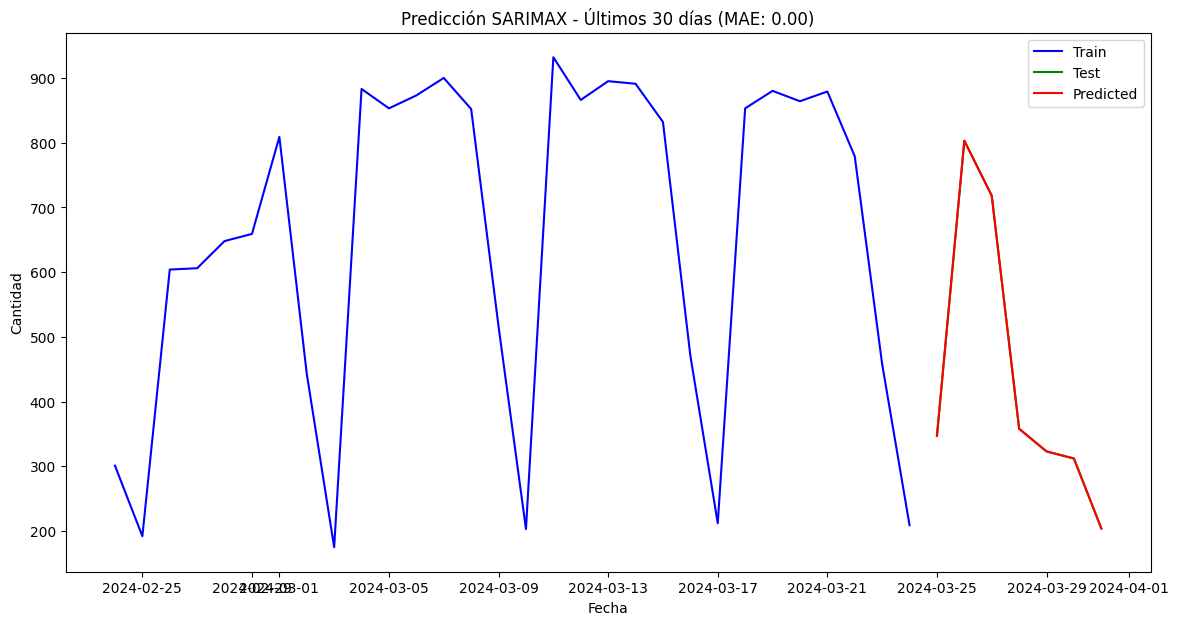

In [166]:

# Graficar las predicciones vs. los valores reales
plt.figure(figsize=(14, 7))

# Últimos 30 días de datos de entrenamiento y prueba
start_date = train_endog.index[-30]

# Datos de entrenamiento
plt.plot(train_endog.loc[start_date:].index, train_endog.loc[start_date:], label='Train', color='blue')

# Datos de prueba
plt.plot(test_endog.index, test_endog, label='Test', color='green')

# Predicciones
plt.plot(test_endog.index, Prediccion_Final_SARIMAX, label='Predicted', color='red')

# Intervalos de confianza
plt.fill_between(test_endog.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='red', alpha=0.3)

# Configuración de la gráfica
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.title(f'Predicción SARIMAX - Últimos 30 días (MAE: {mae:.2f})')
plt.legend()
plt.show()